<a href="https://colab.research.google.com/github/shivg7706/Image-Captioning/blob/master/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!cp ./drive/My\ Drive/Flickr8k_text.zip ./

In [0]:
# !wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
# !unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip
# !rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip

In [0]:
captions = open('Flickr8k.token.txt', 'r').read().strip().split('\n')

In [0]:
import numpy as np

In [0]:
d = {}
for caption in captions:
    caption = caption.split('\t')
    caption[0] = caption[0][:len(caption[0])-2]
    if caption[0] in d:
        d[caption[0]].append(caption[1])
    else:
        d[caption[0]] = [caption[1]]

In [0]:
d

In [0]:
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg16 import VGG16, preprocess_input

In [0]:

with open('Flickr_8k.trainImages.txt', 'r') as f:
    train_images = f.read().strip().split('\n')

In [0]:
with open('Flickr_8k.devImages.txt', 'r') as f:
    val_images = f.read().strip().split('\n')

In [0]:
with open('Flickr_8k.testImages.txt', 'r') as f:
    test_images = f.read().strip().split('\n')

In [12]:
vgg = VGG16(weights='imagenet')

W0716 08:03:25.553755 140129198180224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 08:03:25.585803 140129198180224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 08:03:25.593883 140129198180224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 08:03:25.642839 140129198180224 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0716 08:03:29.702780 140129198180224 deprecation_wrapp

In [0]:
from keras.models import Model

inputs = vgg.input
output = vgg.layers[-2].output

model1 = Model(inputs, output)

In [123]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
def preprocessing(image):
    img = load_img('{}'.format(image), target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return img

In [0]:
def get_encoding_images(image):
    img = preprocessing(image)
    pred = model1.predict(img)
    pred = pred.reshape(4096)
    
    return pred

In [0]:
from tqdm import tqdm_notebook as tqdm

In [0]:
train_encode = {}

for image in train_images:
    train_encode[image] = get_encoding_images(image)

In [0]:
val_encode = {}

for image in val_images:
    val_encode[image] = get_encoding_images(image)

In [0]:
train_text = {}
for i in train_images:
    train_text[i] = d[i]

In [0]:
val_text = {}
for i in val_images:
    val_text[i] = d[i]

#### Adding _start_ and _end_ to each sentences

In [0]:
bhaji = []
for sublist in train_text.values():
    for sen in sublist:
        bhaji.append('<start> {} <end>'.format(sen))

In [0]:
max_length = max([len(sen.split()) for sen in bhaji])

In [0]:
word = []
for sen in bhaji:
    word += sen.split()

In [0]:
words = list(set(word))

In [0]:
vocab_size = len(words)

In [0]:
word2idx = {val:index for index, val in enumerate(words)}
idx2word = {index:val for index, val in enumerate(words)}

In [28]:
idx2word[7706]

'Twome'

In [29]:
word2idx['brightly-lit']

7170

In [0]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(bhaji)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

## Model

In [0]:
from keras.layers import Dense, Input, Dropout, RepeatVector, add, Embedding, LSTM
from keras.utils.vis_utils import plot_model

def cmodel():
    
    input_1 = Input((4096,))
    x = Dropout(0.2)(input_1)
    output_1 = Dense(300, activation='relu')(x)
    

    input_2 = Input((max_length,))
    x = Embedding(vocab_size, 300, mask_zero=True)(input_2)
    output_2 = LSTM(300)(x)
    
    x = add([output_1, output_2])
    x = Dense(300, activation='relu')(x)
    outputs = Dense(vocab_size, activation='softmax')(x)

    model = Model(inputs=[input_1, input_2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='model.png')

    return model
    

In [96]:
model = cmodel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 4096)         0           input_10[0][0]                   
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 300)      2212800     input_11[0][0]                   
__________________________________________________________________________________________________
dense_15 (

In [0]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

def create_sequences(captions_list, image):
    
    X1, X2, y = [], [], []
    for caption in captions_list:
        
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            
            in_seq, out_seq = seq[:i], seq[i]
            
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            out_seq = to_categorical([out_seq], vocab_size)[0]
            
            X1.append(image)
            X2.append(in_seq)
            y.append(out_seq)
    
    return X1, X2, y

In [0]:
def data_generator(batch_size):
    
    np.random.seed(34)
    
    image_ids = list(train_text.keys())
    count = 0 
    
    while True:
        if count >= len(image_ids):
            count = 0
        
        # Batch list to store data
        input_img_batch, input_sequence_batch, output_word_batch = [], [], []
        for i in range(count, min(len(image_ids), count+batch_size)):
            image_id = image_ids[i]
            
            image = train_encode[image_id]
            captions_list = d[image_id]
            
            input_img, input_sequence, output_word = create_sequences(captions_list, image)
            
            for j in range(len(input_img)):
                input_img_batch.append(input_img[j])
                input_sequence_batch.append(input_sequence[j])
                output_word_batch.append(output_word[j])
#             
        count = count + batch_size
#         print(len(input_img_batch), len(input_sequence_batch), len(output_word_batch))
        
        
        yield [[np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch)]

In [98]:
history = model.fit_generator(data_generator(64), epochs=10, steps_per_epoch=500)

Epoch 1/10
500/500 [==============================] - 213s 426ms/step - loss: 0.9771 - acc: 0.7086
Epoch 2/10
500/500 [==============================] - 213s 425ms/step - loss: 0.9251 - acc: 0.7209
Epoch 3/10
500/500 [==============================] - 212s 423ms/step - loss: 0.8672 - acc: 0.7367
Epoch 4/10
500/500 [==============================] - 212s 423ms/step - loss: 0.7955 - acc: 0.7574
Epoch 5/10
500/500 [==============================] - 212s 425ms/step - loss: 0.7602 - acc: 0.7654
Epoch 6/10
500/500 [==============================] - 211s 423ms/step - loss: 0.7312 - acc: 0.7727
Epoch 7/10
500/500 [==============================] - 211s 422ms/step - loss: 0.6725 - acc: 0.7907
Epoch 8/10
500/500 [==============================] - 211s 423ms/step - loss: 0.6238 - acc: 0.8056
Epoch 9/10
500/500 [==============================] - 211s 421ms/step - loss: 0.5958 - acc: 0.8137
Epoch 10/10
500/500 [==============================] - 211s 422ms/step - loss: 0.5816 - acc: 0.8166


In [0]:
model.save('caption.h5')

In [0]:
def generate_caption(image):

    in_text = '<start>'
    image = image.reshape(1, 4096)
    for _ in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        sequence = pad_sequences([sequence], maxlen=max_length)
#         print(sequence.shape)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        
        word = int_to_word(yhat, tokenizer)
        
        if word is None:
            break
        
        in_text += ' ' + word
        
        if word == '<end>':
            break

    return in_text

In [0]:
def int_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [156]:
print(generate_caption(get_encoding_images('test.jpg')))

<start> a young girl and boy sitting on the bench in a park bench with a girl in her dress hand in her hand on her back leg to swallow him in the background and a crowd behind him nearby up


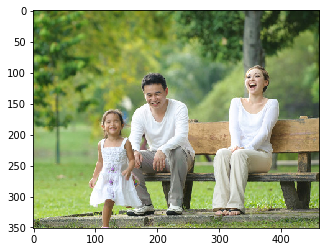

In [155]:
import matplotlib.pyplot as plt
img = plt.imread('test.jpg')
plt.imshow(img)

In [0]:
!cp ./caption.h5 ./drive/My\ Drive